<a href="https://colab.research.google.com/github/rjy1022/my_assets/blob/main/Monte_Carlo_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**BIO/QTM 385: In class exercise for Wednesday, October 7th** 


(answers will be the part of Assignment #4, Due 10/14)

Mack Hutsell, Siwei Xu, June Ro



As always, all questions to be answered will be in <font color="blue"> blue</font> and places to write your answers will be in <font color="green"> green</font>.  Sean and I will be moving through the breakout rooms to help.

In [ ]:
#import useful libraries
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
import numpy.linalg as linalg
from scipy.stats import multivariate_normal
from scipy.stats import cauchy
import pandas as pd

In [ ]:
#@title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")

## Monte Carlo Estimation

As described in class, in Bayesian inference and Bayesian model selection, we are stuck evaluating complicated integrals in high numbers of dimensions that are not ammenable to analytical treatments or brute-force numerical calculations.  Thus, we need to be smarter - building-up our representations through random sampling (hence, [Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_Casino)).  These methods, while more effective than brute force integration, can still take a while to converge, so we will explore how we might be able to tell if our samling has converged and some ideas for speeding-up the process.  While we won't see those advantages in the relatively simple functions you will study today, the same methods allow for the computation of difficult integrals in high-dimensional spaces.

###A Review: Bayesian Inference and Bayesian Model Selection

As described in the lectures, if we have a model, $\mathcal{M}$, with parameters, $\theta$, and a data set, $X$, then in Bayesian inference, we can compute the *posterior* distribution via:

\begin{eqnarray}
p(\theta\vert X,\mathcal{M}) &=& \frac{p(X\vert \theta,\mathcal{M})p(\theta\vert\mathcal{M})}{p(X)} \\
&=& \frac{p(X\vert \theta,\mathcal{M})p(\theta\vert\mathcal{M})}{\int p(X\vert \theta',\mathcal{M})p(\theta'\vert\mathcal{M})d\theta'}.
\end{eqnarray}

While the numerator (the *likelihood* times the *prior*) is typically straight-forward to compute, the denominator is typically impossible (or at least really, really hard!) to compute.  While this difficulty does not present a huge problem in a small number of dimensions (we can numerically integrate to calculate the normalization) or when $p(X\vert \theta,\mathcal{M})p(\theta\vert\mathcal{M})$ is relatively smooth (we can find an approximate solution using fancy math tricks), in most real-world applications, we can't compute the integral without resorting to sampling methods.

**Why do we care that we can't compute the integral?**  After all, it's just a proportionality constant that is applied equally to all values of $\theta$!  One of the key advantages of Bayesian inference is that the output is a posterior probability distribution that we can sample from -- thus we have a sense of the uncertainty of our parameter estimates given the data and our priors.  Without the normalization constant, though, we can't compute the posterior distribution in full, thus limiting out knowledge about the uncertainty.

Similarly, in Bayesian model selection, when we compare two models, $\mathcal{M}_1$ and $\mathcal{M}_2$, we are interested in computing the ratio that we would pick one model over the other given the data:

\begin{equation}
\frac{p(\mathcal{M}_1)}{p(\mathcal{M}_2)} = \frac{p(\mathcal{M}_1)}{p(\mathcal{M}_2)}\frac{p(X\vert\mathcal{M}_1)}{p(X\vert\mathcal{M}_2)}=\frac{\int p(X\vert\mathcal{M}_1,\theta)p(\theta\vert\mathcal{M}_1)d\theta}{\int p(X\vert\mathcal{M}_2,\theta)p(\theta\vert\mathcal{M}_2)d\theta}.
\end{equation}

Thus, we are still tasked with computing an integral of the form $\int p(X\vert\mathcal{M},\theta)p(\theta\vert\mathcal{M})d\theta$, and we will try to figure-out how to achieve this aim in the sections to follow.

###A Made-up Example Function

Here, we will be exploring the function defined and plotted in the code below (```exampleFunction(x)```), which is defined on the interval $x\in [-20,20]$.  This function can be treated as an unnormalized probability distribution (e.g., $p(x) = \frac{f(x)}{Z}$, where $Z$ is unknown).

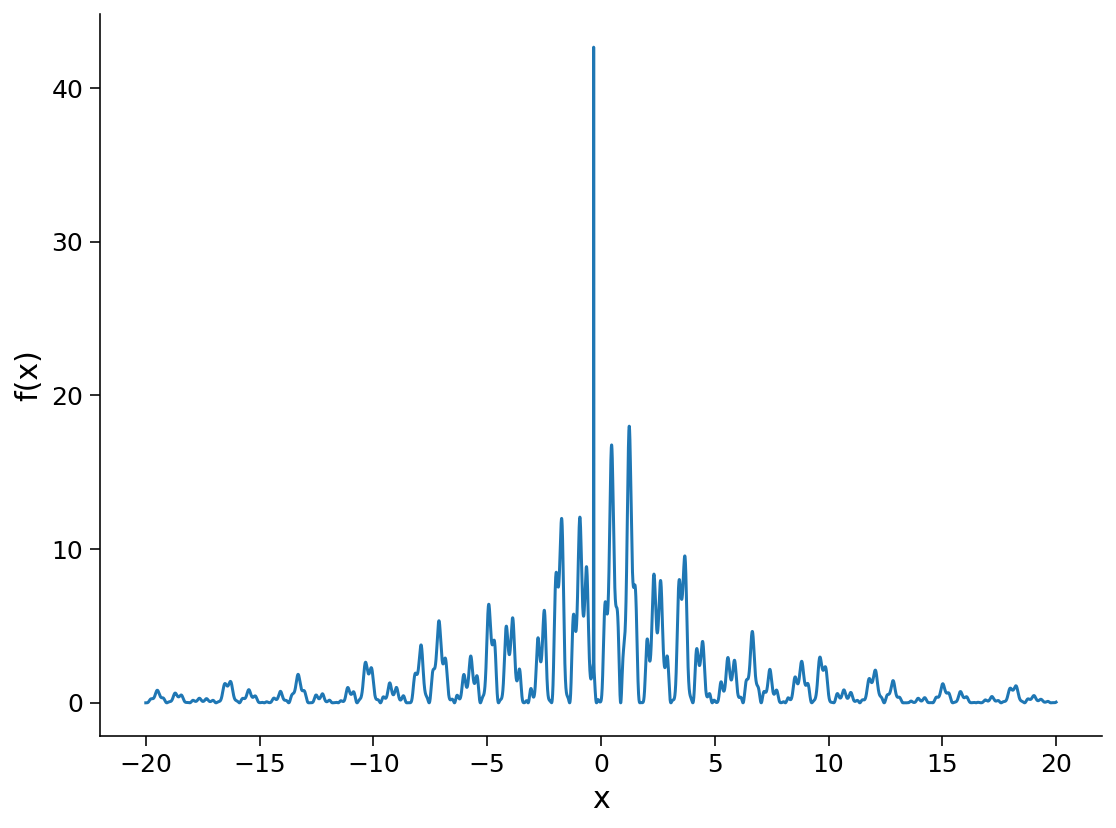

In [ ]:
#Run this code to define exampleFunction
def exampleFunction(x):
  z = .5*np.cos(x+1) - .4*np.cos(2.3*x) - 3*np.cos(3*x-1) + .2*np.cos(7.3*x-2) + 1*np.cos(5.2*x) + .5*np.cos(20.3*x) + 5*np.exp(-.5*(x+.32)**2/.005**2)
  z =  z**2/(1+(x/4)**2)
  z *= np.heaviside(x+20,0)*np.heaviside(20-x,0) + 1e-20
  return z

x = np.arange(-20,20,.0001)
plt.plot(x,exampleFunction(x))
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

As you can see, this is a rather complicated function, and our hopes of integrating it analytically to find $Z$ are rather small.  Thus, we need to try to integrate the function numerically or through sampling.

####Numerical Integration

One tactic that might work is to simply break-up the integral into chunks of size $\Delta x$ and turn sum the function at values $x = -20, -20+\Delta x, -20 +  2\Delta x, \ldots, 20 - \Delta x$.  Thus, 
\begin{equation}
\int_{-20}^{20} f(x)dx \approx \sum_{i=0}^{N=40/\Delta x-1} f(-20 + i\Delta x)\Delta x.
\end{equation}

<font color="blue">Question #1: Numerically evaluate the above sum for ```exampleFunction``` between -20 and 20 (evaluate the sum - don't use any built-in python ```integrate``` functions) for $N=$ ```10**np.arange(1,5,.02)```, and plot the results on a ```plt.semilogx()``` plot of $N$ vs. the integral value.  How large does $N$ need to be before it converges within 1% of the result for $N=10^5$ for all larger $N$?</font>

1.2000000000000002
1.3600000000000003
1.4600000000000004
1.6200000000000006
1.7000000000000006
1.7800000000000007
1.9200000000000008
2.000000000000001
2.080000000000001
2.100000000000001
2.120000000000001
2.140000000000001
2.220000000000001
2.240000000000001
2.260000000000001
2.280000000000001
2.300000000000001
2.320000000000001
2.340000000000001
2.360000000000001
2.4000000000000012
2.4200000000000013
2.4400000000000013
2.4600000000000013
2.4800000000000013
2.5000000000000013
2.5200000000000014
2.5400000000000014
2.5600000000000014
2.6000000000000014
2.6200000000000014
2.6400000000000015
2.6600000000000015
2.6800000000000015
2.7000000000000015
2.7200000000000015
2.7400000000000015
2.7600000000000016
2.7800000000000016
2.8000000000000016
2.8400000000000016
2.8600000000000017
2.8800000000000017
2.9000000000000017
2.9200000000000017
2.9400000000000017
2.9600000000000017
2.9800000000000018
3.020000000000002
3.040000000000002
3.060000000000002
3.080000000000002
3.100000000000002
3.120000000

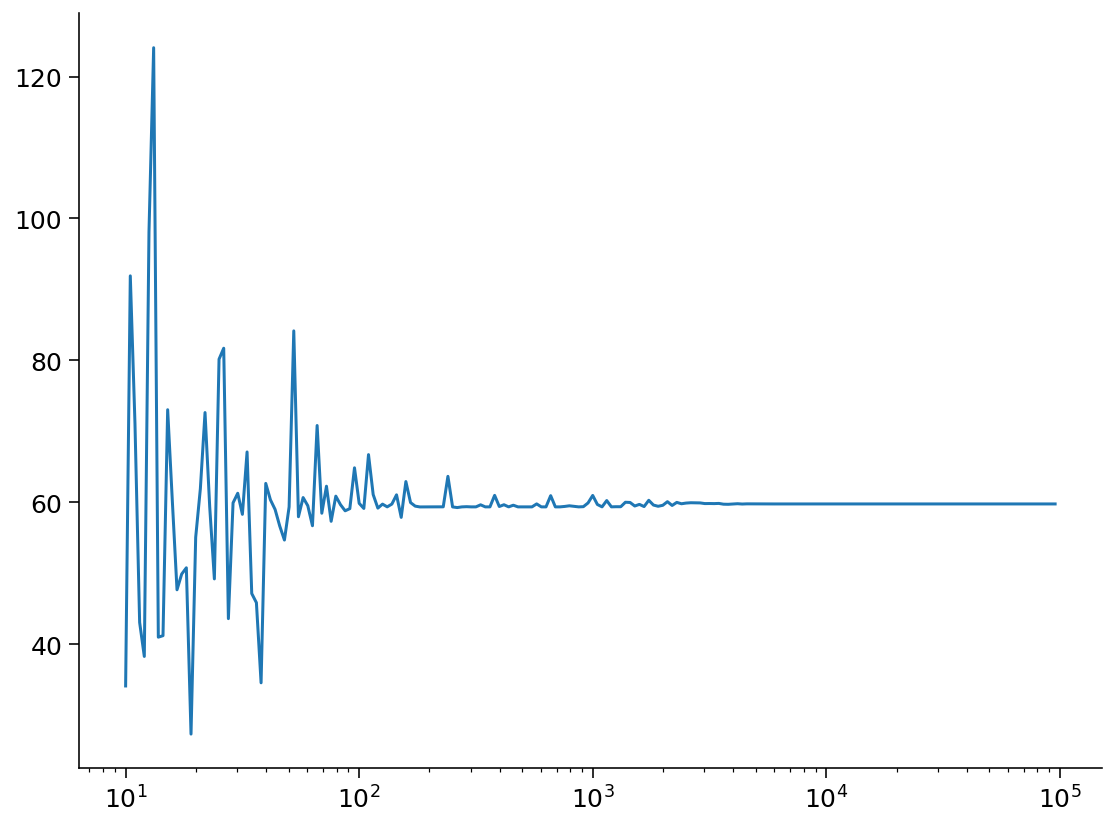

In [ ]:
# solving n = 10^5
n = 10 ** 5
x5 = np.arange(-20,20,40/n)
y5 = sum(exampleFunction(x5)) * 40/n

#Type code for Question #1 here
N = 10 ** np.arange(1,5,0.02)
integrals = []

for step in N:
  deltaX = 40/step
  x = np.arange(-20,20,deltaX)
  y = exampleFunction(x)
  integral = sum(y) * deltaX
  
  if (y5 + .01 * y5) > integral and (y5 - .01 * y5) < integral:
    print(np.log10(step))
  integrals.append(integral)

plt.semilogx(N, integrals)



<font color="green"> How large does $N$ need to be before it converges within 1% of the result for $N=10^5$ for all larger $N$? 

N >= 2.4</font>

<font color=blue>Question #2: Let $\phi(x)=x^3$.  Use your normalization constants from above to estimate and plot $\int_{-20}^{20} \phi(x)p(x)dx\equiv\int_{-20}^{20} \phi(x)\frac{f(x)}{Z}dx$ as a function of $N$ (use the same range as above).  How long until this expectation value converges to be within 1% of the $N=10^5$ result for all larger $N$?</font>

2.9999999999999996
4.6


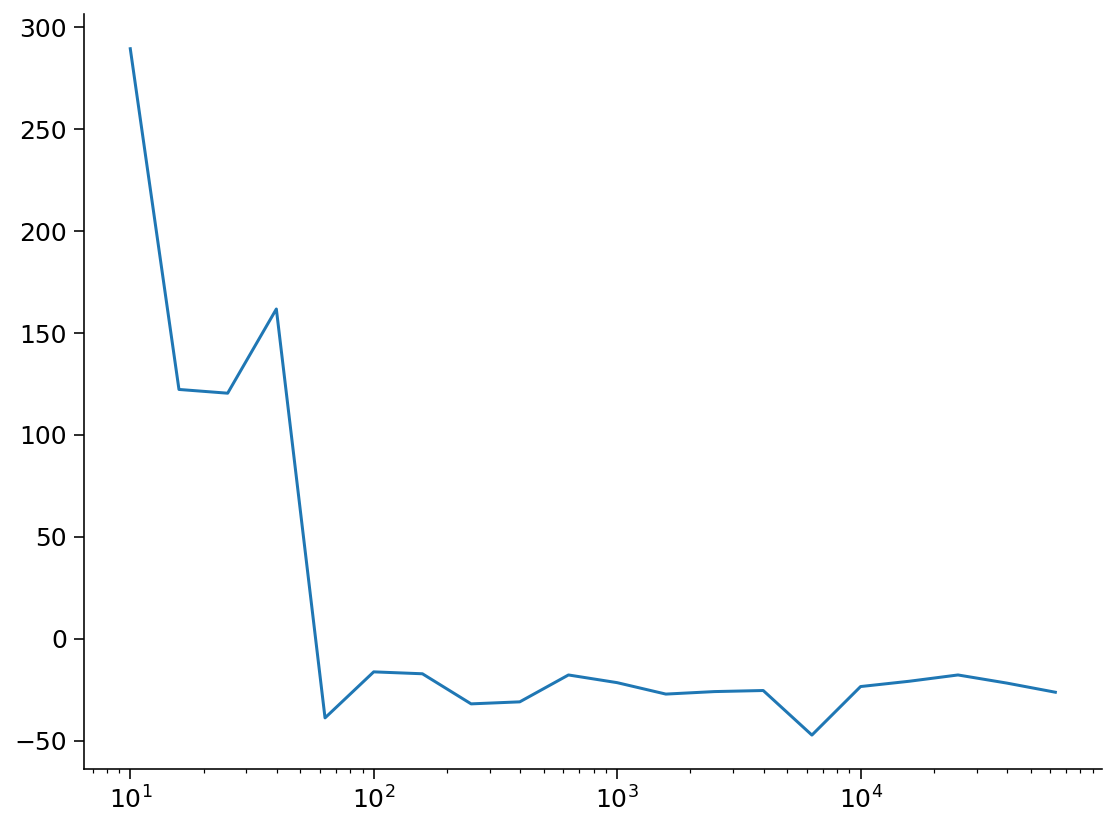

In [ ]:
#Type code for Question #2 here'
def phi(x):
  return x ** 3

# solving n = 10^5
n = 10 ** 5
x5 = np.arange(-20,20,40/n)
y5 = sum((exampleFunction(x5) / integrals[-1]) * phi(x5)) * 40/n

N = 10 ** np.arange(1,5,0.2)
new_integrals = []

for i,step in enumerate(N):
  deltaX = 40/step
  x = np.arange(-20,20,deltaX)
  y = (exampleFunction(x) / integrals[i]) * phi(x)
  integral = sum(y) * deltaX
  if (y5 + .01 * y5) < integral and (y5 - .01 * y5) > integral:
    print(np.log10(step))
  new_integrals.append(integral)

plt.semilogx(N, new_integrals)

<font color=green> How long until this expectation value converges to be within 1% of the  $N=10^5$  result for all larger $N$? 

3.2</font>

Now, let's imagine we have a 2-dimensional function, $g(x,y) = f(x)g(y+1)$, as shown and plotted in the cell below.

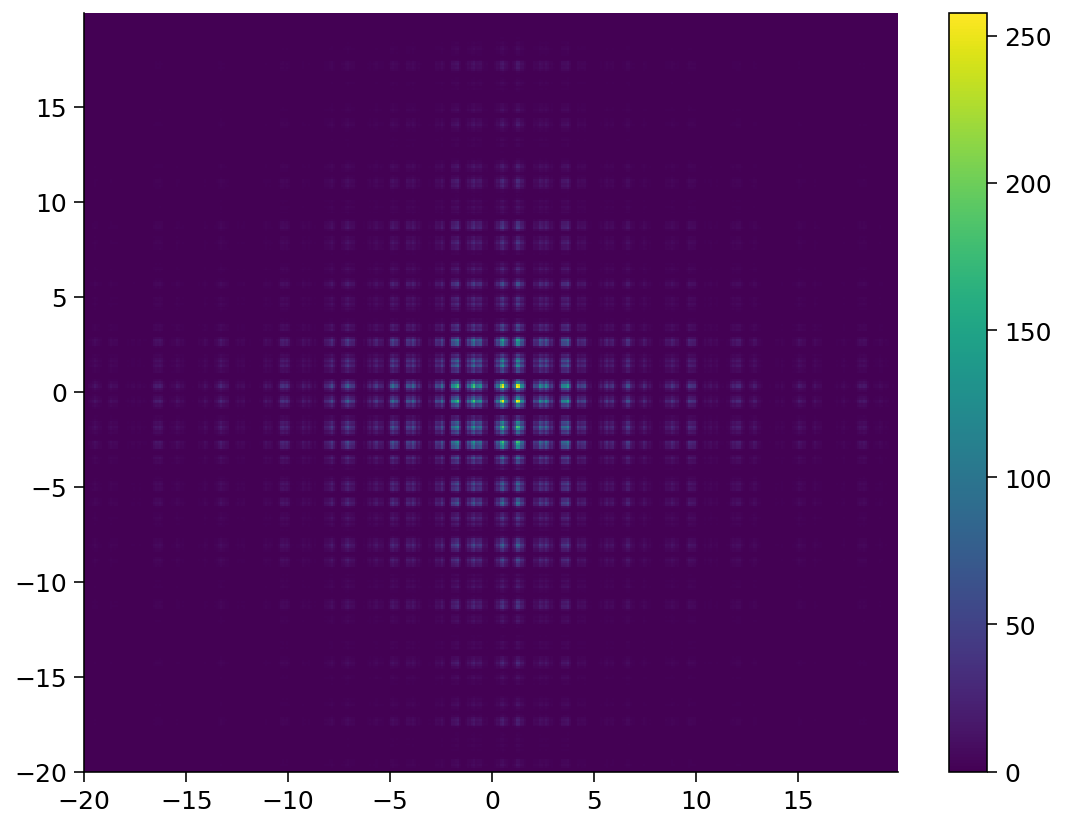

In [ ]:
def exampleFunction2d(x,y):
  return exampleFunction(x)*exampleFunction(y+1)

x = np.arange(-20,20,.1)
y = np.arange(-20,20,.1)
X,Y = np.meshgrid(x,y)
Z = exampleFunction2d(X,Y)
im = plt.pcolormesh(x,y,Z)
plt.colorbar()
plt.show()

To calculation the integral of $g(x,y)$ numerically, we could perform the same approximation as before, now just with an additional summation:
\begin{equation}
\int_{-20}^{20}\int_{-20}^{20}g(x,y)dx dy\approx \sum_{i=0}^{N_x=40/\Delta x-1}\sum_{j=0}^{N_y=40/\Delta y-1} g(-20 + i\Delta x,-20 + j\Delta y)\Delta x \Delta y.
\end{equation}

<font color=blue>Question #3: Using numerical integration, how many times do you anticipate having to evaluate $g(x,y)$ in order to obtain an accurate (within 1%) estimate of the integral? (Note: no need to actually simulate - just make your best guess of the answer from evidence obtained in your answer to Question #1) </font> 

<font color=green> Write your answer to Question #3 here 

Before our step size was 40 / (10 ^ 2.4). Now, we would expect that step size would have to be smaller, something like: 40 / (10 ^ 4.8).</font>

<font color=blue>Question #4: The same as above in Question #3, but now for estimating $\int_{-20}^{20}\int_{-20}^{20}\zeta(x,y)g(x,y)dx dy$, with $\zeta(x,y)\equiv x^3y^3$?

<font color=green> Write your answer to Question #3 here 

Before our step size was 40 / (10 ^ 3.2). Now, we would expect that step size would have to be smaller, something like: 40 / (10 ^ 6.4).</font>

####Random Sampling

Returning back to our 1D function, ```exampleFunction()```, we could also try to compute the integral through random sampling, uniformly, on the interval $x\in[-20,20]$.

<font color = blue>Question #5: Select 1,000,000 random samples out of a uniform distribution between -20 and 20 (```random.uniform()``` is the function of interest).  Plot a running talley of your estimate of $\int_{-20}^{20} \phi(x)f(x)dx$ as a function of the number of samples using ```np.cumsum()```.  By the end, has your solution converged to within 1% of your value for $N=10^5$ in Question #2?  If so, did the convergence take more, fewer, or the same number of function evaluations compared to your answer to Question #2?

(Hint: you can compute the estimate by taking the mean value of your $f(x_i)\phi(x_i)$ draws and divide by the mean value of your $f(x_i)$ draws to create a weighted average)</font>

101950
integral: -21.619423361456086
final estimate: -20.811909490948334


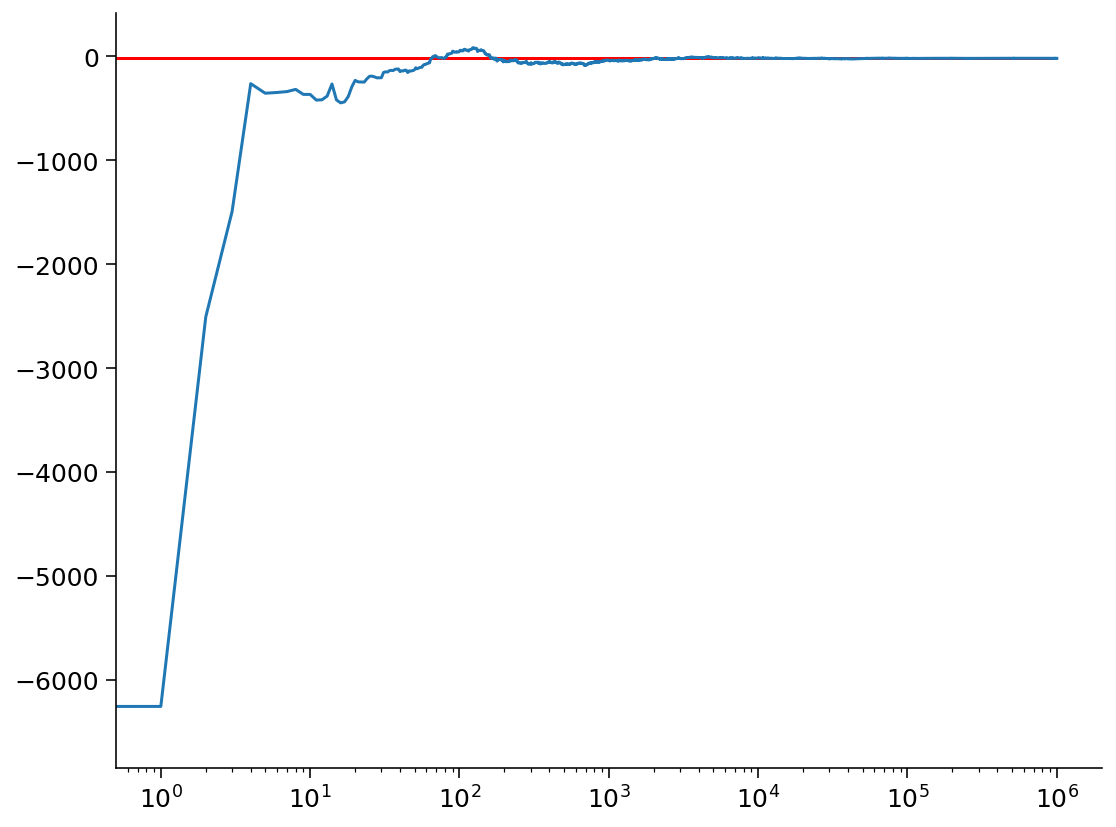

In [ ]:
#Type your code for Question #5 here
N = random.uniform(-20,20, size=1000000)
exf_Y = exampleFunction(N)
phi_Y = phi(N)
Y = phi_Y * exf_Y

running_avg = np.cumsum(Y) / np.cumsum(exf_Y)
plt.semilogx(running_avg)
plt.hlines(y5,0,1000000,'r')
count = 0
for i, x in enumerate(running_avg):
  if (y5 + .01 * y5) < x and (y5 - .01 * y5) > x:
    count += 1
  if count > 5000:
    print(i)
    break
  
print("integral:" ,y5)
print("final estimate:", running_avg[-1])

<font color=green> By the end, has your solution converged to within 1% of your value for $N=10^5$ in Question #2?  If so, did the convergence take more, fewer, or the same number of function evaluations compared to your answer to Question #2?

Ours takes about many more (20times - NaN) function evaluations, but it usually does converge.</font>

####Importance Sampling

As you should have seen in the previous question, uniform sampling usually won't help us much, so we need to find a new strategy.  The next potential idea is to make a guess for $p(x)$, the underlying distribution.  Let's call that guess $q(x)$.  The idea is that we can easily sample from $q(x)$, and if that if $q(x)$ allows for a better sampling of $p(x)$ than a uniform distribution, we can create a weighted average, where samples from $q$ from areas where $f(x)=p(x)*Z$ is large are enhanced and samples from $q$ where $f(x)$ is relatively small are diminished.

More precisely, we define:
\begin{equation}
w_i = \frac{f(x_i)}{q(x_i)},
\end{equation}
where $x_i$ is the $i^{th}$ draw from $q(x)$.  Thus, to compute an expectation value, we can compute the weighted sum:
\begin{equation}
\hat\Phi = \frac{\sum_{i=1}^N w_i \phi(x_i)}{\sum_{i=1}^N w_i}.
\end{equation}

<font color=blue>Question #6: Let $q(x) = \mathcal{N}(0,100)$, a normal distribution with mean of zero and variance ($\sigma^2$) equal to 100.  Generate $N=$1,000,000 samples from $q$ and plot a running tally of your estimate for $\int_{-20}^{20} \phi(x)p(x)dx$.  Has your estimate or your convergence time improved over uniform sampling?</font>

-22.71355655812885
21034


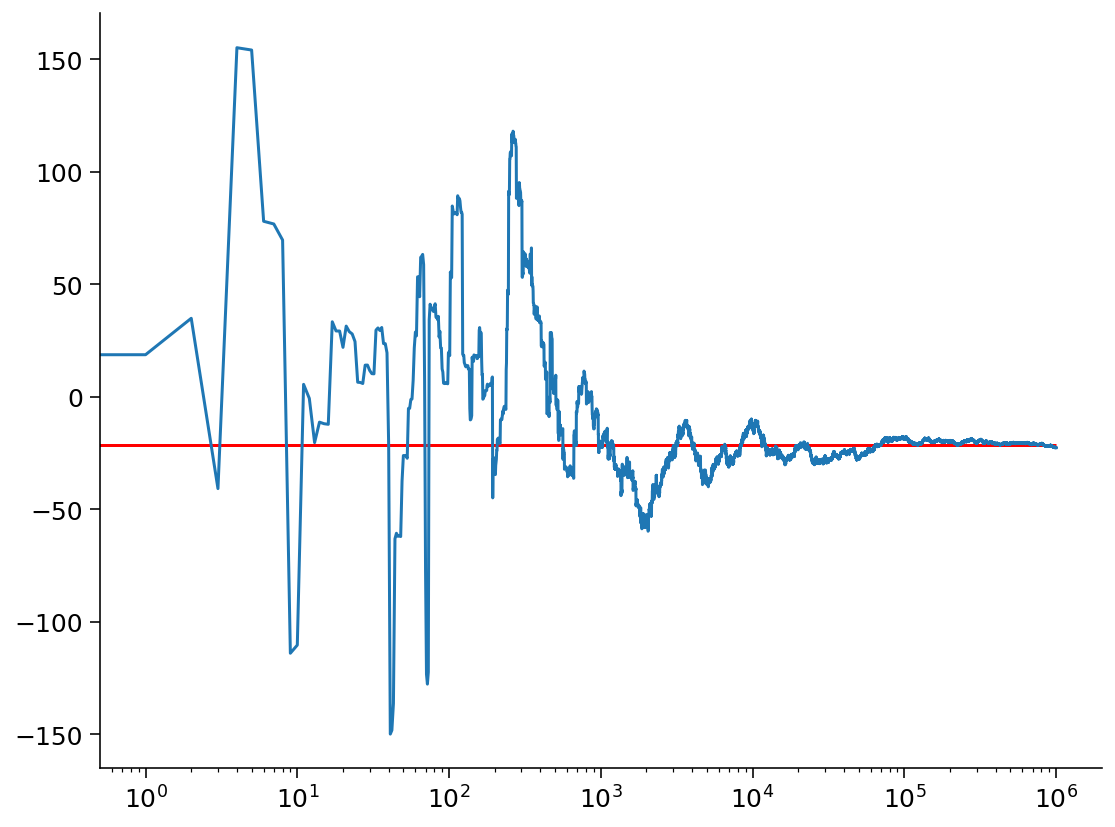

In [ ]:
#Type your answer to Question #6 here
Nq = random.normal(0,10,size=1000000)

exf_Y = exampleFunction(Nq)
phi_Y = phi(Nq)
G = np.exp(-.5*Nq**2/100)/np.sqrt(2*np.pi*100)
wi = exf_Y / G
Y = phi_Y * wi
expectation = np.sum(Y) / np.sum(wi)
print(expectation)

running_avg = np.cumsum(Y) / np.cumsum(wi)
count = 0
for i, x in enumerate(running_avg):
  if (y5 + .01 * y5) < x and (y5 - .01 * y5) > x:
    count += 1
  if count > 500:
    print(i)
    break

plt.semilogx(running_avg)
plt.hlines(y5,0,1000000,'r')

<font color=green>Has your estimate or your convergence time improved over uniform sampling?

Yes, about 10x faster usually. It ultimately converged, but it took many more evaluations until it reached that point.
</font>

##Metropolis-Hastings Sampling

Importance sampling generates new samples out of the global distribution $q(\vec{x})$, but often it is beneficial to sample locally - spending more time around areas of particularly high probability.  This is where Markov Chain Monte Carlo (MCMC) methods can be particularly useful.  For now, we will start with Metropolis-Hastings sampling.

In Metropolis-Hastings sampling, we start from a randomly-chosen starting point (usually randomly-chosen from our prior), $\vec{x}^{(0)}$.  From here, we iterate through the dimensions of $\vec{x}^{(0)}$, selecting a new point each time or sticking with the old one.  There are many ways of choosing the next point to test, but for now, let's say that we choose a new point, $\tilde{x}_i$, out of a Gaussian distribution with mean $x^{(0)}_i$ and variance $\sigma^2$ ($\mathcal{N}(x^{(0)}_i,\sigma^2)$).  We then decide whether to keep this suggested new point or not in our sampled data within the context of the algorithm below:

0) Initialize $\sigma$

1) Initialize $\vec{x}^{(t)}$ and calculate $f(\vec{x}^{(t)})$ ($\vec{x}^{(t)}\in \mathcal{R}^p$)

2) Let $\vec{x}^{(t)}\to \vec{x}^{(t+1)}$ 

3) For $i = 1,2,\dots,p$:
  
   (i) $\vec{x}^{(t+1)} \to \tilde{x}$

   (ii) $x^{(t)}_i + \eta \to \tilde{x}_i $ ($\eta$ drawn from $\mathcal{N}(0,\sigma^2)$ 

   (iii) Calculate $a \equiv \frac{f(\tilde{x})}{f(\vec{x}^{(t+1)})}$

   (iv) If $a\ge 1$, then $\tilde{x}\to \vec{x}^{(t+1)}$

   (v) If $a<1$, then $\tilde{x}\to \vec{x}^{(t+1)}$ with probability $a$ (no change otherwise)

4) $t+1\to t$

5) Repeat Steps 2-4 until you decide to stop

Once a set of $\{\vec{x}^{(t)}\}_{t=1,\dots, N}$ are obtained, then we usually assume that there is a "burn-in" time, $m$, that represents the effect of our initial value on the simulation, and we can calculate an expectation value of the function $\phi(\vec{x})$ via:
\begin{equation}
\hat{\Phi} = \frac{1}{N-m}\sum_{t=m+1}^N \phi(\vec{x}^{(t)})
\end{equation}

<font color=blue>Question #7: Write a function, ```runMetropolisHastingsExample(N,sigma)```, that implements the algorithm above for the 1d ```exampleFunction(x)```, running for ```N``` times through the loop (Steps 2-5) with $\sigma=$ ```sigma```. The code should pick an initial value $x^{(0)}$ at random from [-1,1] and should return ```xs```, an (```N```$+1)\times 1$ array of the simulated $x^{(t)}$.  (Note: since the example function is 1-d ($p=1$) you don't need to implement the for loop in Step 3 above)</font>

In [ ]:
#Type code for Question #7 here
def runMetropolisHastingsExample(N,sigma):
  xs = []
  x0 = random.random()*2-1
  x1=x0
  for i in range(0,N):
    muX = x1+random.normal(0,sigma)
    a = exampleFunction(muX)/exampleFunction(x1)

    if(a>=1):
      xs.append(muX)
      x1 = muX
    elif (random.random()<a):
      xs.append(muX)
      x1=muX
    else:
      xs.append(x1)

  return xs

<font color=blue>Question #8: Run your simulation code above for $\sigma=$.05 and $N=$1,000,000, and plot a histogram of the resulting values (assume a burn-in time of $m=$100,000).  Do your results look simlar to the original function?  Would you prefer Monte Carlo simulation or numerical integration in a single dimension?  Why? </font>

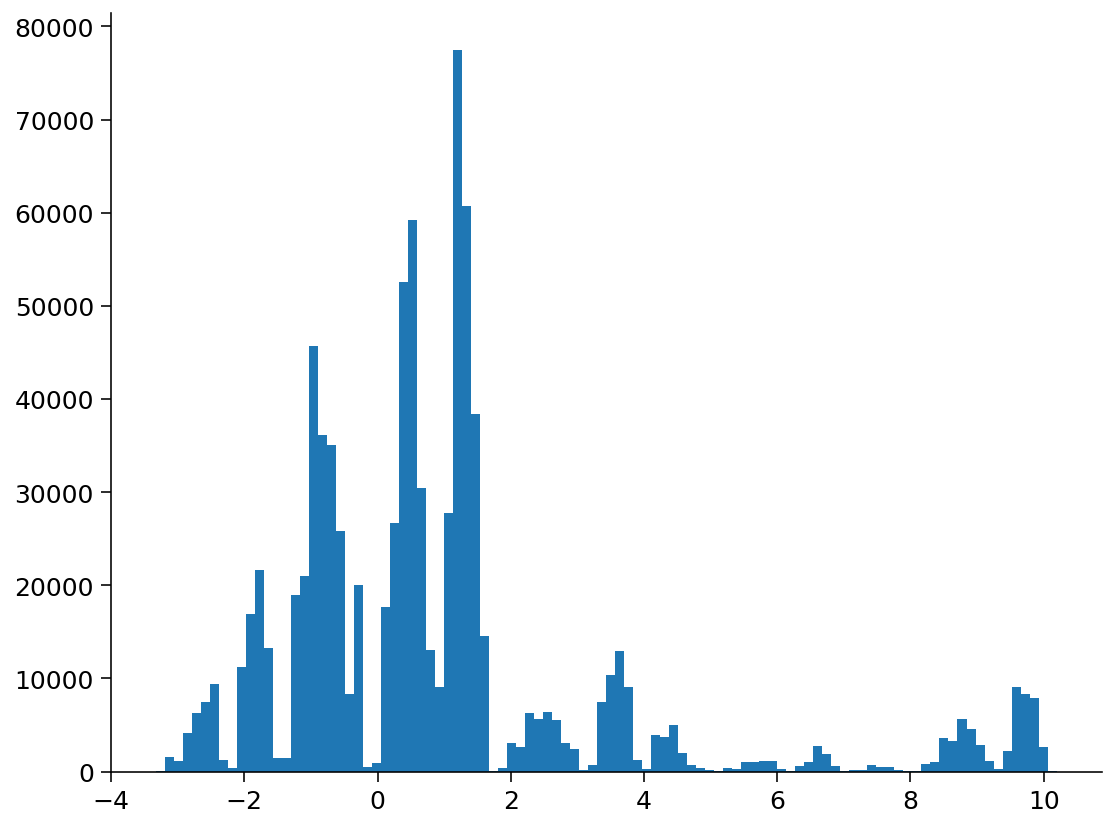

In [ ]:
#Type your code for Question #8 here
N = 1000000
m = 100000
xss = runMetropolisHastingsExample(N,0.05)
arr = np.array(xss)

ys = arr[m+1:]

plt.hist(ys, bins=100)
plt.show()

<font color="green"> Do your results look simlar to the original function?  Would you prefer Monte Carlo simulation or numerical integration in a single dimension?  Why? 

The results look kind of similar to the original function since it resembles a bell-shaped curve but the peak is around -2 here wehereas that of the original function is around 0. Although it is complex in its steps, I would prefer Monte Carlo simulation because it allows for flexibility. I think the complex steps actually reduce the uncertainty in our estimates, so it would predict the model more accurately than a single dimension.
</font>

###Testing for convergence

In real-world examples, we typically don't know what the answer is (this is why we do the numerical calculation!), so we lack a ground-truth to convince us that our results have converged.  The general idea is that we were to run the simulation many times, we would like the variation between chains to be comparable to the variation within the chain.  The most common statistical test for this type of convergence is the Gelman-Rubin convergence diagnostic.

To be more precise, let's imagine that we make $M$ independent Monte Carlo simulations, each run for $n+N$ time steps ($n$ is our burn-in time).  Let $\vec{\mu}^{(i)}$ and $\sigma^{(i)}$ be the mean and standard deviation of the post burn-in data for simulation $i$.  In addition, let's define $\bar{\mu}$ as the mean of all of the $\vec{\mu}_i$ values.

Thus, if we focus on one of the dimensions, $i$, that we are interested in, we can define the **between simulation** variance ($B$) via the variance in the simulations mean values:
\begin{equation}
B = \frac{N}{M-1} \sum_{m=1}^M (\mu^{(m)}_i - \bar{\mu}_i)^2
\end{equation}
and the **within simulation** variance ($W$) is given by the average of the post-burn-in variances within each simulation:
\begin{equation}
W = \frac{1}{M} \sum_{m=1}^M (\sigma^{(m)}_i)^2.
\end{equation}
Ideally, we would compute these quantities for all dimensions, but we will focus on the 1-d problem today for the sake of simplicity.

Unfortunately, we can't just look at the ratios of these quantities for a variety of complicated reasons that are beyond the scope of this class (see [here](https://projecteuclid.org/download/pdf_1/euclid.ss/1177011136) for details), we can write-down an unbiased estimator of the posterior variance of our estimated parameter as the pooled variance, $V$:
\begin{equation}
V = \frac{N-1}{N} W + \frac{M+1}{MN}B.
\end{equation}
$V$ serves as an effective between simulation variance measure.

Given these quantities (and correcting for the number of dimensions, $p$, in our estimate, a statistical comparison between the within and between simulation variance is given via the **Gelman-Rubin Convergence Diagnostic**:
\begin{equation}
R_c = \sqrt{\frac{p+3}{p+1}\frac{V}{W}}
\end{equation}
(phew).  While somewhat difficult to derive, this diagnostic is relatively easy to compute, and we generally say that a simulation has converged if $R_c<1.1$.

While it might seem numerically expensive to run the simulation $M$ times, the simulations are all completely independent from each other.  Accordingly, they can be run in parallel, so on a large system, running multiple instantiations often takes a similar amount of real-world time as running a single chain(although not a similar amount of total CPU time, naturally).  If you want to try parallelizing your code for the question below, a tutorial is [here](https://colab.research.google.com/drive/1nMDtWcVZCT9q1VWen5rXL8ZHVlxn2KnL#scrollTo=gWQm3RSn52aK).

<font color=blue>Question #9: Using your function from Question #7, run $M=5$ simulations of length $N$=220,000 ($\sigma=$.05).  Calculate $R_c$. Would you say that your simulation has converged? Assume a burn-in time of $n=$20,000 time steps. (If you're curious, you can try to increase $N$ to see if you can lower $R_c$)</font>

In [ ]:
#Type your code for Question #9 here
N = 220000
M = 5
sigma = 0.05
m = 20000
runMetropolisHastingsExample(N,sigma)

means = []
sds = []
for i in range(0,M):
  mu = runMetropolisHastingsExample(N+m, sigma)
  mean = np.array(mu)
  mean = mean[m+1:]
  means.append(np.mean(mean))
  sds.append(np.std(mean))

sum = 0
muX = np.mean(means)
for i in means:
  sum = sum + (i-muX) ** 2

B = N/(M-1) * sum

sumSd = 0
for i in sds:
  sumSd = sumSd + i**2

W = sumSd/M
V = ((N-1)*W/N) + ((M+1)/(M*N)*B)
Rc = np.sqrt(2*V/W)

print(Rc)

1.50320445612018


<font color=green> Would you say that your simulation has converged? 

Since Rc>1.1, it hasn't converged.</font>